# !["julia logo"](figs/julialogo-smaller.png)

Julia is an open-source scientific programming language that blends the best of its predecessors

  * **easy as Matlab**: numeric, interactive, similar syntax, built-in libraries, plotting
  * **fast as Fortran**: user-written interactive Julia code runs as fast as compiled Fortran
  * **flexible as Python**: modern, dynamic, general-purpose, extensible, batteries included
  * **deep as Lisp**: Julia code can operate on and transform Julia code *(homoiconic)*
  * with robust packaging and installation system integrated with git


Background

  * origins at MIT, UCSB Applied Math & Computer Science, 2010     
  * spawned Julia Hub LLC, 2015, ~100 employees        
  * ~10-person core language team, ~1000 contributors, ~1000 registered packages     
  * julia-1.0 released 2018 
  * www.julialang.org, github.com/JuliaLang/julia, discourse.julialang.org

In [1]:
using LinearAlgebra, ODE, Plots, GenericSVD, FFTW     # load packages

# Julia: easy as Matlab

Julia is a drop-in replacement for Matlab for interactive calculations with built-in numerical libraries and plotting. A few examples...

### Linear algebra 

In [2]:
A = randn(4,4)        # 4 x 4 matrix of normally distributed random numbers

4×4 Matrix{Float64}:
 -1.05858   -0.210521  -0.339349  -0.522768
 -0.446456   0.665112  -0.681259  -1.39706
 -0.281302  -1.5356     1.25836   -0.805783
 -0.582095   0.309054   1.15798   -0.251063

In [3]:
A[:,1]                # familiar colon syntax --extract first column of A

4-element Vector{Float64}:
 -1.058584529476853
 -0.4464555255278073
 -0.28130163035714617
 -0.5820946941498428

In [4]:
b = randn(4)          
x = A\b               # solve Ax=b for x using backslash operator
norm(A*x-b)

2.7755575615628914e-16

In [5]:
U, σ, V = svd(A);     # singular value decomposition --note unicode variable name σ

In [6]:
Σ = diagm(σ)
norm(A - U*Σ*V')      # compute error of SVD factorization A = U Σ V'

2.6091717397327452e-15

In [7]:
@which lu(A)

lu(A::AbstractMatrix{T}, args...; kwargs...) where T
     @ LinearAlgebra ~/.julia/juliaup/julia-1.11.7+0.x64.linux.gnu/share/julia/stdlib/v1.11/LinearAlgebra/src/lu.jl:341

### Numerical integration of differential equation

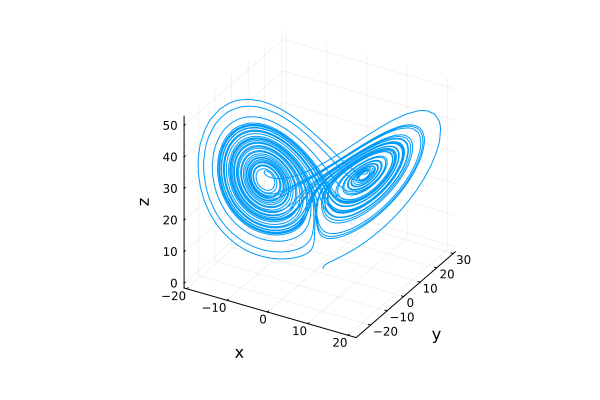

In [8]:
# define Lorenz dynamics dx/dt = lorenz(t,x)
function lorenz(t, x)
    σ = 10
    β = 8/3
    ρ = 28
    [σ*(x[2]-x[1]); x[1]*(ρ-x[3]); x[1]*x[2] - β*x[3]]
end

# integrate dx/dt = lorenz(t,x) numerically from t=0 to t=50 and starting point x₀
tspan = 0:0.01:50.0
x₀ = [2.0; 0.0; 0.0]
t,x = ode45(lorenz, x₀, tspan)
y = x
x = hcat(x...)';

# plot Lorenz attractor
plot(x[:,1], x[:,2], x[:,3], l=:path3d, xlab="x", ylab="y", zlab="z", label="")

### Don't try this in Matlab...

Some examples of Julia's comprehensive numeric types and superior notation!

In [9]:
⊕ = (x,y) -> 3x + 2y       # define ⊕ operator (unicode program text)

#1 (generic function with 1 method)

In [10]:
@show 5 ⊕ 1;               # apply ⊕ to two Int64s

5 ⊕ 1 = 17


In [11]:
@show 2//5 ⊕ (3 - 7im);  
@show 5 ⊕ 1;               
# Rational{Int64} ⊕ Complex{Int64} -> Complex{Rational{Int64}

2 // 5 ⊕ (3 - 7im) = 36//5 - 14//1*im
5 ⊕ 1 = 17


In [12]:
setprecision(1024)
@show BigFloat(pi)          # show π as a 1024-bit floating-point number

BigFloat(pi) = 3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724586997


3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724586997

In [13]:
2.6 - 1.9 - 0.7

2.220446049250313e-16

In [14]:
2^(-52)

2.220446049250313e-16

In [15]:
BigFloat(π)

3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724586997

# Julia: fast as Fortran

Interactive Julia code runs as fast as compiled Fortran (when written properly). A demo on a nonlinear PDE:

### Kuramoto-Sivashinsky equation

The Kuramoto-Sivashinsky (KS) equation is a nonlinear time-evolving partial differential equation (PDE) on a 1d spatial domain.

\begin{equation*}
u_t = - u_{xx} - u_{xxxx} - u u_x
\end{equation*}

where $x$ is space, $t$ is time, and subscripts indicate differentiation. We assume a spatial domain $x \in [0, L_x]$ with periodic boundary conditions and initial condition $u(x,0) = u_0(x)$.

<img style="float:center" src="figs/ksdynamics.png"/>


### Numerical integration algorithm: KS-CNAB2

Represent the linear terms as $Lu = (-D^2 -D^4)\, u$ and the nonlinear term as $N(u) = 1/2\, D \,u^2$ where $D = \partial/\partial x$.

\begin{equation*}
u_t = Lu + N(u)
\end{equation*}

Discretize time by letting $u^n(x) = u(x, n\Delta t)$ for some small $\Delta t$, and use Crank-Nicolson, Adams-Bashforth (CNAB2) timestepping. 

\begin{equation*}
\frac{u^{n+1} - u^n}{\Delta t} = L\left(\frac{u^{n+1} + u^n}{2} \right) + \frac{3}{2} N(u^n) - \frac{1}{2} N(u^{n-1})
\end{equation*}


Put the unknowns (future) $u^{n+1}$'s on the LHS and knowns (present) $u^{n}$ and (past) $u^{n-1}$ on the RHS.

\begin{equation*}
\left(I  - \frac{\Delta t}{2} L \right) u^{n+1} = \left(I  + \frac{\Delta t}{2}L \right) u^{n} + \frac{3 \Delta t}{2} N(u^n) - \frac{\Delta t}{2} N(u^{n-1})
\end{equation*}

Discretize space with a Fourier transform, so that $u$ becomes a vector of Fourier coefficients, $(I  \pm \Delta t/2 \, L)$ become
the diagonal matrices $A$ and $B$, and $N^n$ is the Fourier transform of $N(u^n)$.

\begin{equation*}
A \, u^{n+1} = B \, u^n + \frac{3 \Delta t}{2} N^n -  \frac{\Delta t}{2}N^{n-1}
\end{equation*}

This is an $Ax=b$ problem whose iteration approximates the time-evolution of the Kuramoto-Sivashinksy PDE. 

### Julia code for KS-CNAB2 algorithm

In [16]:
function ksintegrate(u₀, Lₓ, Δt, Nsteps, nsave);
    uⁿ = (1+0im)*u₀                      # force u to be complex
    Nₓ = length(uⁿ)                      # number of gridpoints
    kₓ = vcat(0:Nₓ/2-1, 0:0, -Nₓ/2+1:-1) # integer wavenumbers, used in exp(2πikₓ x/L)
    α  = 2*pi*kₓ/Lₓ                      # real wavenumbers, used in exp(iαx)
    D  = 1im*α                           # spectral D = d/dx operator 
    L  = α.^2 - α.^4                     # spectral L = -D^2 - D^4 operator
    G  = -0.5*D                          # spectral -1/2 D operator
    
    Nsave = div(Nsteps, nsave)+1         # number of saved u's, including t=0
    t = (0:Nsave-1)*(Δt*nsave)           # times of saved u's
    U = zeros(Nsave, Nₓ)                 # matrix of u(tᵢ, xⱼ) values
    U[1,:] = real(u₀)                    # assign initial condition to U
    s = 2                                # counter for saved data
    
    # construct diagonal matrices for LHS and RHS linear operators
    I   = ones(Nₓ)
    A⁻¹ = (I - Δt/2*L).^(-1)             
    B   = I + Δt/2*L
    
    # compute in-place FFTW plans
    FFT!  = plan_fft!(uⁿ,  flags=FFTW.ESTIMATE)
    IFFT! = plan_ifft!(uⁿ, flags=FFTW.ESTIMATE)

    # initialize nonlinear terms 
    Nuⁿ  = G.*fft(uⁿ.^2)      # set Nuⁿ = -1/2 d/dx (uⁿ)² = -u uₓ 
    Nuⁿ⁻¹ = copy(Nuⁿ)         # set Nuⁿ⁻¹ = Nuⁿ for first time step
    FFT!*uⁿ
    
    # timestepping loop
    for n = 0:Nsteps-1
        
        Nuⁿ⁻¹ .= Nuⁿ        # shift nonlinear term in time
        Nuⁿ  .= uⁿ         # store uⁿ in Nuⁿ in prep for collocation computation
        
        IFFT!*Nuⁿ          # transform to gridpt values of u
        Nuⁿ .= Nuⁿ.*Nuⁿ    # collocation calculation of u²
        FFT!*Nuⁿ           # transform u² back to spectral coeffs

        Nuⁿ .= G.*Nuⁿ      # compute  Nuⁿ = -1/2 d/dx u² = -u uₓ

        # Loop fusion! Julia unrolls this line into a single for-loop over vector elems,
        # avoiding the generation and allocation of temporary vectors you'd get in Matlab
        uⁿ .= A⁻¹ .* (B .* uⁿ .+ (3Δt/2).*Nuⁿ .- (Δt/2).* Nuⁿ⁻¹)
        
        if mod(n, nsave) == 0
            U[s,:] = real(ifft(uⁿ))  # save into return matrix U 
            s += 1            
        end
    end
   
    t,U
end

ksintegrate (generic function with 1 method)

### Execute Julia KS-CNAB2 code

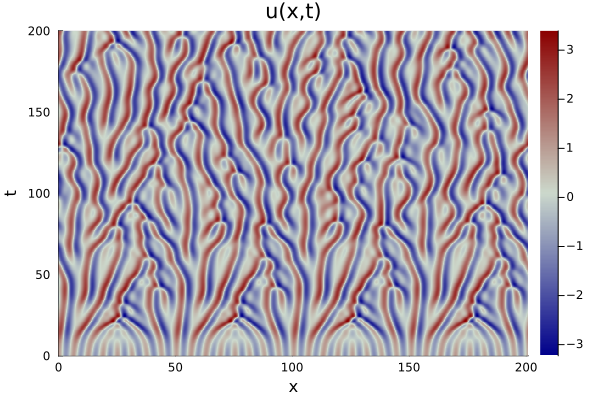

In [17]:
# set discretization parameters
Lx = 64π
Nx = 1024
Δt = 1/16
nsave = 8
Nsteps = 3200

# set initial condition
x = Lx*(0:Nx-1)/Nx
u₀ = cos.(x) + 0.1*sin.(x/8) + 0.002*cos.(x/32);

# compile the integrator function by running it one time step
t,U = ksintegrate(u₀, Lx, Δt, 8, nsave)

# integrate the PDE
t,U = ksintegrate(u₀, Lx, Δt, Nsteps, nsave) 

# plot results
heatmap(x,t, U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), 
    xlabel="x", ylabel="t", title="u(x,t)", fillcolor=:bluesreds
)

### KS-CNAB2 benchmark: CPU time of identical algorithm in six languages. 

Takeaway: Julia is nearly as fast as C and Fortran, within a few percent. Codes: [ks.py](https://github.com/johnfgibson/whyjulia/tree/master/ks-codes/ksbenchmark.py#48)
 [ks.m](https://github.com/johnfgibson/whyjulia/tree/master/ks-codes/ksbenchmark.m#46) 
 [ks.jl](https://github.com/johnfgibson/whyjulia/tree/master/ks-codes/ksbenchmark.jl#L129) [ks.c](https://github.com/johnfgibson/whyjulia/tree/master/ks-codes/ksbenchmark.c#L82) [ks.cpp](https://github.com/johnfgibson/whyjulia/tree/master/ks-codes/ksbenchmark.cpp#L87) [ks.f90](https://github.com/johnfgibson/whyjulia/tree/master/ks-codes/ksbenchmark.f90#L84) 

![cpu scaling on KS eqn](figs/ks_cpu_scaling.png)

### KS-CNAB2 benchmark: CPU time versus lines of code 

Takeaway: The Julia PDE code is almost as compact as Matlab/Python, almost as fast as C/Fortran.
![cpu time vs lines of code](figs/ks_cpu_vs_lines_1024.png)


### Benchmarks on common code pattterns

Takeaway: Julia timings are clustered around C timing, Matlab/Python/R orders of magnitude slower.
![microbenchmarks](figs/benchmarks.png)

# 

### Logistic map benchmark: Julia, C, Matlab

The logistic map is a 1d discrete-time dynamical system defined by $x_{n+1} = f(x_n)$ where $f(x) = 4x(1-x)$ and $x \in [0,1]$.

Let $~~f^N(x) = f(\,f(\,...(\,f(\,f(x)))))$ be the millionth iterate of $f$, with $N=10^6$.

#### $f^N$ in Julia

(needlessly fancy)

In [18]:
f(x) = 4x*(1-x) # logistic function

# given g(x), return function g^N(x) = g(g(...(g(g(x)))))
function iterator(g, N)
    
    # construct gᴺ, the Nth iterate of g
    function gᴺ(x)
       for i ∈ 1:N             
          x = g(x)
       end        
       return x
    end    
    
    return gᴺ
end

fᴺ = iterator(f, 10^6);  # generate millionth iterate funcion fᴺ(x) for f(x) = 4x(1-x)

fᴺ(0.67)                 # run fᴺ(x) once to compile it

0.10116885334547539

#### $f^N$ in C++, compiled

In [19]:
; cat codes/fN.cpp

#include <stdlib.h>
#include <iostream>
#include <iomanip>
#include <ctime>

using namespace std;

inline double f(double x) {
  return 4*x*(1-x);
}

int main(int argc, char* argv[]) {
  double x = argc > 1 ? atof(argv[1]) : 0.0;

  double t0 = clock();
  for (int n=0; n<1000000; ++n)
    x = f(x);
  double t1 = clock();

  cout << "t = " << (t1-t0)/CLOCKS_PER_SEC << " seconds" << endl;
  cout << setprecision(17);
  cout << "x = " << x << endl;
  
  return 0;
}
  


 Compile fN.cpp in Unix shell

In [20]:
; g++ -O3 -o fN codes/fN.cpp -lm 

### Compare execution time of $f^N$ in Julia, C++, Matlab

#### Julia

In [21]:
print("t=");
@time x = fᴺ(0.67);         # run the Julia fᴺ on x = 0.67
@show x;

t=  0.002713 seconds (1 allocation: 16 bytes)
x = 0.10116885334547539


In [22]:
; fN 0.67 

t = 0.003003 seconds
x = 0.10116885334547539


#### C++

In [23]:
; fN 0.67

t = 0.002979 seconds
x = 0.10116885334547539


Julia and C++ get the same result `x` in roughly same execution time `t`. Sometimes Julia is faster, sometimes C++.

#### Matlab (nonlive result)
```
>> tic(); x=fN(0.67); t=toc();
>> t, x
t = 0.048889000000000
x = 0.101168853345475
```
Matlab gets the same result $x$, but ten to twenty times slower than Julia or C++.

# Just-in-time compilation 

Observe the compilation of $f(x)$ by stages

user Julia -> generic Julia expression -> typed Julia expression -> intermediate compiler language -> machine code

In [24]:
f(x) = 4x*(1-x)        # the user code

f (generic function with 1 method)

In [25]:
@code_lowered f(0.3)  # show f(x) as generic Julia expression

CodeInfo(
1 ─ %1 = Main.:*
│   %2 = 4 * x
│   %3 = 1 - x
│   %4 = (%1)(%2, %3)
└──      return %4
)

In [26]:
@code_typed f(0.3)    # show f(x) as Julia expr with inferred types, based on the arg types

CodeInfo(
1 ─ %1 = Base.mul_float(4.0, x)::Float64
│   %2 = Base.sub_float(1.0, x)::Float64
│   %3 = Base.mul_float(%1, %2)::Float64
└──      return %3
) => Float64

In [27]:
@code_llvm f(0.3)    # show f(x) in intermediate compiler language (LLVM)

; Function Signature: f(Float64)
;  @ In[24]:1 within `f`
define double @julia_f_14208(double %"x::Float64") #0 {
top:
; ┌ @ promotion.jl:430 within `*` @ float.jl:493
   %0 = fmul double %"x::Float64", 4.000000e+00
; └
; ┌ @ promotion.jl:431 within `-` @ float.jl:492
   %1 = fsub double 1.000000e+00, %"x::Float64"
; └
; ┌ @ float.jl:493 within `*`
   %2 = fmul double %0, %1
   ret double %2
; └
}


In [28]:
@code_native f(0.3) # show f(x) in IA-64 assembly language

	.text
	.file	"f"
	.section	.rodata.cst8,"aM",@progbits,8
	.p2align	3, 0x0                          # -- Begin function julia_f_14385
.LCPI0_0:
	.quad	0x4010000000000000              # double 4
.LCPI0_1:
	.quad	0x3ff0000000000000              # double 1
	.text
	.globl	julia_f_14385
	.p2align	4, 0x90
	.type	julia_f_14385,@function
julia_f_14385:                          # @julia_f_14385
; Function Signature: f(Float64)
; ┌ @ In[24]:1 within `f`
# %bb.0:                                # %top
; │ @ In[24] within `f`
	#DEBUG_VALUE: f:x <- $xmm0
	push	rbp
	mov	rbp, rsp
	movabs	rax, offset .LCPI0_0
; │ @ In[24]:1 within `f`
; │┌ @ promotion.jl:430 within `*` @ float.jl:493
	vmulsd	xmm1, xmm0, qword ptr [rax]
	movabs	rax, offset .LCPI0_1
	vmovsd	xmm2, qword ptr [rax]           # xmm2 = mem[0],zero
; │└
; │┌ @ promotion.jl:431 within `-` @ float.jl:492
	vsubsd	xmm0, xmm2, xmm0
; │└
; │┌ @ float.jl:493 within `*`
	vmulsd	xmm0, xmm1, xmm0
	pop	rbp
	ret
.Lfunc_end0:
	.size	julia_f_14385, .Lfunc_e

## Type inference

Julia reasons about types and infers types of variables from context, enabling compilation to hardware instructions. 

Language and type system carefully designed maximize effectiveness of just-in-time compilation. Matlab, Python syntax precludes this.

### Type inference on $f(x)$

In [29]:
# recall definition of f(x): no types are mentioned!
f(x) = 4x*(1-x)

f (generic function with 1 method)

In [30]:
@code_llvm f(0.3)   # intermediate compiler code for f applied to Float64 argument

; Function Signature: f(Float64)
;  @ In[29]:2 within `f`
define double @julia_f_14454(double %"x::Float64") #0 {
top:
; ┌ @ promotion.jl:430 within `*` @ float.jl:493
   %0 = fmul double %"x::Float64", 4.000000e+00
; └
; ┌ @ promotion.jl:431 within `-` @ float.jl:492
   %1 = fsub double 1.000000e+00, %"x::Float64"
; └
; ┌ @ float.jl:493 within `*`
   %2 = fmul double %0, %1
   ret double %2
; └
}


In [31]:
@code_llvm f(2)     # intermediate compiler code for f applied to Int64 argument

; Function Signature: f(Int64)
;  @ In[29]:2 within `f`
define i64 @julia_f_14459(i64 signext %"x::Int64") #0 {
top:
; ┌ @ int.jl:88 within `*`
   %0 = shl i64 %"x::Int64", 2
; └
; ┌ @ int.jl:86 within `-`
   %1 = sub i64 1, %"x::Int64"
; └
; ┌ @ int.jl:88 within `*`
   %2 = mul i64 %0, %1
   ret i64 %2
; └
}



# Julia: flexible as Python

Python is known for the richness of its built-in types and the ease with which new types can be defined. Julia is similar, and it has a comprehensive set of built-in numeric types that Python lacks. 

### Comprehensive built-in numeric type system

In [32]:
# define a set of various numeric types
X = (1, 0.5f0, 0.5, 2//3, 2+3im, 2.1 + 4.3im, 2//3 + 4//5im, BigFloat(2//3), BigFloat(2//3) + BigFloat(4//5)*im);

# loop over elements of X, print type and compute value of logistic map f(x)
for x ∈ X
    println("typeof(x) = $(typeof(x)), f(x) = $(f(x))\n")
end

typeof(x) = Int64, f(x) = 0

typeof(x) = Float32, f(x) = 1.0

typeof(x) = Float64, f(x) = 1.0

typeof(x) = Rational{Int64}, f(x) = 8//9

typeof(x) = Complex{Int64}, f(x) = 28 - 36im

typeof(x) = ComplexF64, f(x) = 64.72 - 55.04im

typeof(x) = Complex{Rational{Int64}}, f(x) = 776//225 + 16//15*im

typeof(x) = BigFloat, f(x) = 0.8888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888877

typeof(x) = Complex{BigFloat}, f(x) = 3.448888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888893 - 1.06666

In [33]:
# exact arithmetic: compute 7th iterate of logisitic map on Rational{BigInt}
f⁷ = iterator(f, 7)

@show x = f⁷(big(2//3));

x = f⁷(big(2 // 3)) = 674838593766753484487654913831820720085359667709963001167872//11790184577738583171520872861412518665678211592275841109096961


In [34]:
typeof(x)

Rational{BigInt}

### Singular values of Hilbert matrix

The Hilbert matrix $A_{ij} = (i+j-1)^{-1}$ is notoriously ill-conditioned. 

In [35]:
#using LinearAlgebra
m = 8
A = [1//(i+j-1) for i=1:m, j=1:m]    # 8 x 8 Hilbert matrix of Rationals

8×8 Matrix{Rational{Int64}}:
  1    1//2  1//3   1//4   1//5   1//6   1//7   1//8
 1//2  1//3  1//4   1//5   1//6   1//7   1//8   1//9
 1//3  1//4  1//5   1//6   1//7   1//8   1//9   1//10
 1//4  1//5  1//6   1//7   1//8   1//9   1//10  1//11
 1//5  1//6  1//7   1//8   1//9   1//10  1//11  1//12
 1//6  1//7  1//8   1//9   1//10  1//11  1//12  1//13
 1//7  1//8  1//9   1//10  1//11  1//12  1//13  1//14
 1//8  1//9  1//10  1//11  1//12  1//13  1//14  1//15

In [36]:
# 16 x 16 Hilbert is too ill-conditioned for 64-bit arithmetic: cond(A) ≈ 1/ϵ₆₄
m = 16
A = [1/(i+j-1) for i=1:m, j=1:m]    # 16 x 16 Hilbert matrix of Float64s
@show cond(A)
@show eps(Float64)

cond(A) = 2.249940193352714e18
eps(Float64) = 2.220446049250313e-16


2.220446049250313e-16

In [37]:
σ = svdvals(A)

16-element Vector{Float64}:
 1.8600364427433271
 0.4401314363623381
 0.06111426291630711
 0.006297815269922941
 0.0005146753583779205
 3.4127569716590114e-5
 1.852975362843348e-6
 8.253135278279444e-8
 3.0045761617374087e-9
 8.861707852011017e-11
 2.085931128322003e-12
 3.8274152359495635e-14
 5.372491836850746e-16
 1.2397801390670778e-17
 1.1287361442480794e-17
 8.267048378613221e-19

In [38]:
# Make 32 x 32 Hilbert matrix of 256-bit BigFloats and show a few elements
setprecision(256)
m = 32
A = [BigFloat(1//(i+j-1)) for i=1:m, j=1:m]; 
@show A[1,1]
@show A[2,1]
@show A[3,1]
;

A[1, 1] = 1.0
A[2, 1] = 0.5
A[3, 1] = 0.3333333333333333333333333333333333333333333333333333333333333333333333333333348


In [39]:
# Compute singular values of 32 x 32 Hilbert matrix in 256-bit arithmetic
using GenericSVD
σ = svdvals(A)

32-element Vector{BigFloat}:
 1.998434811479943656818393069323257960640895672475752391825234214538557962751588
 0.5862023373833755450036553769152732128253887467482456889981306320710605366320062
 0.1108475234522936411657120190769169868529406706066854975505612888253343305563977
 0.01673319658958179140677531975263979754746187466404676472020306095015480020192898
 0.002155754915541528367548783984537708307586547078248680464675678773027369214112337
 0.0002430276596697422938228473142877594100259722632966877505528956749837836051975856
 2.429495582927391325328945583959494719139547266197054564322197618596025730313687e-05
 2.171522505963389703148618411661941671277063234196349157743888780845209556761463e-06
 1.744940782252377496458626015544168389499120927266562258019751784656307459777646e-07
 1.265263755175621542941323081140106746391741410303876700785990407921028262195971e-08
 8.299361818990081080483039727963430527712415734657494874743550521365934360909455e-10
 4.93222550281255168996015409037686168

# <font color="red"> Code from here down needs updating </font>

## User-defined type: Galois field GF(p)

Finite scalar field GF(p) is $\mathbb{Z}/p$, the integers modulo p, where p is prime. Example by Andreas Noack, Julia Computing.

In [40]:
# Type definition: Galois fields GF(p), where p is prime modulus, T is integer type
immutable GF{p,T} <: Number where {p,T<:Integer}
    rep::T  # representative integer which holds the value of a GF(p) variable
    function GF{p,T}(x::Integer) where {p,T<:Integer}
        return new(mod(x, p))
    end
end

LoadError: UndefVarError: `immutable` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [41]:
# Type definition: Galois fields GF(p), where p is prime modulus, T is integer type
immutable GF{p,T} <: Number where {p,T<:Integer}
    rep::T  # representative integer which holds the value of a GF(p) variable
    function GF{p,T}(x::Integer) where {p,T<:Integer}
        return new(mod(x, p))
    end
end
GF{p}(x::T) where {p,T<:Integer} = GF{p,T}(x)


# Define some basic methods for GF(p) that all Julia Numbers must have
import Base: convert, inv, one, promote_rule, show, zero

function call{p}(::Type{GF{p}}, x::Integer)
    if !isprime(p)
        throw(ArgumentError("p must be prime"))
    end
    return GF{p,typeof(x)}(mod(x, p))
end

convert{p,T}(::Type{GF{p,T}}, x::Integer) = GF{p}(x)
convert{p}(::Type{GF{p}}, x::Integer) = GF{p}(x)
convert{p,T}(::Type{GF{p,T}}, x::GF{p}) = GF{p,T}(x.rep)
promote_rule{p,T1,T2<:Integer}(::Type{GF{p,T1}}, ::Type{T2}) = GF{p,promote_type(T1,T2)}
show(io::IO, x::GF) = show(io, x.rep);


# Define arithmetic operations on GF(p)
import Base: +, -, *, /

for op in (:+, :-, :*)   # loop over ops, defining each in terms of integer ops mod p
    @eval begin
        ($op){p,T}(x::GF{p,T}, y::GF{p,T}) = GF{p,T}($(op)(x.rep, y.rep))
    end
end

# Define inverse and ÷. Requires more care than +, -, * because dividing by zero throws error
function inv{p,T}(x::GF{p,T})
    if x == zero(x)
        throw(DivideError())
    end
    r, u, v = gcdx(x.rep, p)
    GF{p,T}(u)
end
(/){p}(x::GF{p}, y::GF{p}) = x*inv(y);

LoadError: UndefVarError: `immutable` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [42]:
subtypes(Number)

5-element Vector{Any}:
 Base.MultiplicativeInverses.MultiplicativeInverse
 Complex
 Plots.Measurement
 Real
 Static.StaticInteger

In [43]:
# Create some GF(7) variables and do arithmetic

x = GF{7}(9)   # x =  9 mod 7 = 2
y = GF{7}(12)  # y = 12 mod 7 = 5
@show x
@show y
@show x + y     # 2 + 5 mod 7 = 0
@show x - y     # 2 - 5 mod 7 = 4
@show x * y     # 2 * 5 mod 7 = 3
@show x / y     # 2 ÷ 5 mod 7 = 6, because 2 = 6*5 mod 7
;

LoadError: UndefVarError: `GF` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Linear algebra over Galois field

In [44]:
srand(1234)
A = [GF{7}(rand(0:6)) for i = 1:4, j = 1:4] # matrix of random GF(7) elems

LoadError: UndefVarError: `srand` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [45]:
b = [GF{7}(rand(0:6)) for i = 1:4]          # random vector b for Ax=b problem

LoadError: UndefVarError: `GF` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [46]:
x = A\b   # solve Ax=b over GF(p)!

LoadError: DimensionMismatch: arguments must have the same number of rows

In [47]:
A*x - b   # check that x satisfies Ax=b

LoadError: DimensionMismatch: a has size (32, 32), b has size (4,), mismatch at dim 1

**Whoa! Built-in backslash operator on matrix of GF(p) worked!** 

Julia generated and compiled a GF(p)-specific version of its generic LU decomp function. 

All it needs is definitions of $+, -, \times, \div$.

<br> <br> <br> <br>




# Julia: deep as Lisp

Julia is *homoiconic*: it can represent its own expressions as data structures and operate on them. 

### Expressions

In [48]:
program = "for n ∈ 1:N begin println(n^2) end end"

"for n ∈ 1:N begin println(n^2) end end"

In [49]:
expression = parse(program)

LoadError: MethodError: no method matching parse(::String)
The function `parse` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  parse([91m::Type{Union{}}[39m, Any...; kwargs...)
[0m[90m   @[39m [90mBase[39m [90m[4mparse.jl:39[24m[39m
[0m  parse([91m::Type{VersionNumber}[39m, [91m::AbstractString[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mversion.jl:146[24m[39m
[0m  parse([91m::Type{Base.UUID}[39m, [91m::AbstractString[39m)
[0m[90m   @[39m [90mBase[39m [90m[4muuid.jl:83[24m[39m
[0m  ...


In [50]:
typeof(expression)

LoadError: UndefVarError: `expression` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [51]:
dump(expression)   # show expression as an abstract syntax tree

LoadError: UndefVarError: `expression` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [52]:
program

"for n ∈ 1:N begin println(n^2) end end"

In [53]:
N = 3; eval(parse(program))

LoadError: MethodError: no method matching parse(::String)
The function `parse` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  parse([91m::Type{Union{}}[39m, Any...; kwargs...)
[0m[90m   @[39m [90mBase[39m [90m[4mparse.jl:39[24m[39m
[0m  parse([91m::Type{VersionNumber}[39m, [91m::AbstractString[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mversion.jl:146[24m[39m
[0m  parse([91m::Type{Base.UUID}[39m, [91m::AbstractString[39m)
[0m[90m   @[39m [90mBase[39m [90m[4muuid.jl:83[24m[39m
[0m  ...


In [54]:
N = 5; eval(parse(program))

LoadError: MethodError: no method matching parse(::String)
The function `parse` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  parse([91m::Type{Union{}}[39m, Any...; kwargs...)
[0m[90m   @[39m [90mBase[39m [90m[4mparse.jl:39[24m[39m
[0m  parse([91m::Type{VersionNumber}[39m, [91m::AbstractString[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mversion.jl:146[24m[39m
[0m  parse([91m::Type{Base.UUID}[39m, [91m::AbstractString[39m)
[0m[90m   @[39m [90mBase[39m [90m[4muuid.jl:83[24m[39m
[0m  ...


### Macros: code that transforms code

In [55]:
# @show macro prints expression, an equals sign, then evaluates the expr and prints its value
@show 3*A[:,1] + 7*A[:,2];

3 * A[:, 1] + 7 * A[:, 2] = BigFloat[6.5, 3.833333333333333333333333333333333333333333333333333333333333333333333333333356, 2.75, 2.150000000000000000000000000000000000000000000000000000000000000000000000000014, 1.766666666666666666666666666666666666666666666666666666666666666666666666666682, 1.5, 1.303571428571428571428571428571428571428571428571428571428571428571428571428581, 1.152777777777777777777777777777777777777777777777777777777777777777777777777774, 1.033333333333333333333333333333333333333333333333333333333333333333333333333329, 0.9363636363636363636363636363636363636363636363636363636363636363636363636363677, 0.8560606060606060606060606060606060606060606060606060606060606060606060606060711, 0.7884615384615384615384615384615384615384615384615384615384615384615384615384649, 0.7307692307692307692307692307692307692307692307692307692307692307692307692307719, 0.6809523809523809523809523809523809523809523809523809523809523809523809523809619, 0.63750000000000000000000000000000000000

In [56]:
# @time macro inserts timing and memory profiling into expression, then evaluates, and prints
@time f(2//3)

  0.000000 seconds


8//9

In [57]:
# @which macro determines which function is called, provides link to source code on GitHub
@which exp(π)

exp(x::Real)
     @ Base.Math math.jl:1528

In [58]:
@which exp(π*im)

exp(z::Complex)
     @ Base complex.jl:701

In [59]:
# run-time code generation and evaluation using @eval macro (from prior example, Galois field GF(p))

for op in (:+, :-, :*)   # loop over ops, defining each in terms of integer ops mod p
    @eval begin
        ($op){p,T}(x::GF{p,T}, y::GF{p,T}) = GF{p,T}($(op)(x.rep, y.rep))
    end
end

LoadError: UndefVarError: `p` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Macros enable run-time code generation and transformation. Applications

  * generation and execution of boilerplate code
  * run-time generation and optimization of algorithms, e.g. FFTW, ATLAS
  * symbolic mathematics, automatic differentiation
  * *all written like high-level Python, running like compiled C !!!*

## Parallelism in Julia: MPI plus native constructs

Some very trivial examples of Julia's built-in parallelism

In [60]:
workers()

LoadError: UndefVarError: `workers` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Distributed in the current active module Main

In [61]:
addprocs(2)

LoadError: UndefVarError: `addprocs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Distributed in the current active module Main

#### Remote procedure calls

In [62]:
; cat codes/count_heads.jl

function count_heads(n)
    c::Int = 0
    for i=1:n
        c += rand(Bool)
    end
    c
end


In [63]:
@everywhere include("codes/count_heads.jl")

a = @spawn count_heads(10000000)
b = @spawn count_heads(10000000)
fetch(a)+fetch(b)

LoadError: LoadError: UndefVarError: `@everywhere` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Distributed in the current active module Main
in expression starting at In[63]:1

### Parallel loops with reduction

In [64]:
nheads = @parallel (+) for i=1:200000000
  Int(rand(Bool))
end

LoadError: LoadError: UndefVarError: `@parallel` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at In[64]:1

### Shared arrays

In [65]:
a = SharedArray{Float64}(10)
@parallel for i=1:10
  a[i] = i
end

LoadError: UndefVarError: `SharedArray` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [66]:
a

LoadError: UndefVarError: `a` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Distributed arrays

In [67]:
@everywhere using DistributedArrays

LoadError: LoadError: UndefVarError: `@everywhere` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Distributed in the current active module Main
in expression starting at In[67]:1

In [68]:
A = @DArray [i+j for i = 1:5, j = 1:5]

LoadError: LoadError: UndefVarError: `@DArray` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at In[68]:1

In [69]:
@which sum(A)

sum(arr::AbstractArray{BigFloat})
     @ Base.MPFR mpfr.jl:848

In [70]:
B = drandn(5,5)

LoadError: UndefVarError: `drandn` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [71]:
C = A+B

LoadError: UndefVarError: `B` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [72]:
C[3,2]

LoadError: UndefVarError: `C` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Conclusions

Julia
  * **easy as Matlab, fast as Fortran, flexible as Python, deep as Lisp**
  * poised to take over scientific computing, from interactive exploration to HPC

Not covered
  * large-scale programming, development ecosystem, environments, debuggers, etc.
  * function calls to C, Fortran, Python (direct, no glue code)
  * interfaces to major C/Fortran libraries, e.g. LAPACK, MPI, FFTW, PETSc, etc.   
  * rough edges: plotting, package loading times, pre-1.0 syntax flux

Thanks
  * Julia team, Julia community
  * David Sanders, National University of Mexico City
  * Andreas Noack, Julia Computing 
  * Mahtab Lak, UNH Math Ph.D. student

  
Julia website: http://www.julialang.org, this talk: https://github.com/johnfgibson/whyjulia
<br> <br> <br>  <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br> <br>

#### Preload and run some functions

In [73]:
using ODE, Plots, GenericSVD     # load some packages 
gr();                            # set plotting backend
t = linspace(0,4π)
x,y,z = cos.(t), sin.(t), t
plot(x, y, z, l=:path3d, xlab="x", ylab="y", zlab="z", label="")

LoadError: UndefVarError: `linspace` not defined in `Main`
Suggestion: check for spelling errors or missing imports.